<a href="https://colab.research.google.com/github/Akhilez/ml_gallery/blob/master/ml_py/MLGallery/selective_generator/colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model

```yaml
Generator:
  - Input: 100 (90 noise, 10 one-hot)
  - h1: 150
  - h2: 400
  - h3: 784

FeatureExtractor:
  - Input: 784 (28x28)
  - h1: 400
  - h2: 150
  - h3: 100

Discriminator:
  - Input: 100
  - h1: 50
  - h2: 1

Classifier:
  - Input: 100
  - h1: 50
  - h2: 10
```

Link to file: https://github.com/Akhilez/ml_gallery/blob/master/ml_py/MLGallery/selective_generator/colab.ipynb

In [0]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from torch.nn.functional import dropout, leaky_relu, binary_cross_entropy, softmax
from torch import sigmoid
from torch.nn import Conv2d, Linear, ConvTranspose2d

In [25]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
data_path = "./data/mnist/"

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(data_path, train=True, download=True,
                               transform=torchvision.transforms.ToTensor()), shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(data_path, train=False, download=True,
                               transform=torchvision.transforms.ToTensor()), shuffle=True)

Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw


Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw


Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw


Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw
Processing...
Done!


In [0]:
def to_one_hot(x):
    b = np.zeros((len(x), 10))
    b[np.arange(len(x)), x] = 1
    return b

In [0]:
x_test = []
y_test = []

for data in test_loader:
    x_test.append(data[0].reshape(1, 28, 28).numpy())
    y_test.append(data[1][0])

y_test = torch.Tensor(to_one_hot(y_test))
x_test = torch.Tensor(x_test)

In [0]:
x_train = []
y_train = []

for data in test_loader:
    x_train.append(data[0].reshape(1, 28, 28).numpy())
    y_train.append(data[1][0])

y_train = torch.Tensor(to_one_hot(y_train))
x_train = torch.Tensor(x_train)

In [0]:
x_train = x_train[:5000]
x_test = x_test[:500]
y_train = y_train[:5000]
y_test = y_test[:500]

In [9]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

print(torch.min(x_test))
print(torch.max(x_test))

print(y_train[0])

torch.Size([1000, 1, 28, 28]) torch.Size([100, 1, 28, 28]) torch.Size([1000, 10]) torch.Size([100, 10])
tensor(0.)
tensor(1.)
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])


In [0]:
def plot_image(x):
    plt.imshow(x, cmap='gray')
    plt.show()

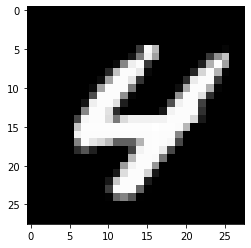

tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])


In [11]:
index = 13
plot_image(x_test[index].numpy().reshape((28, 28)))
print(y_test[index])

In [0]:
def get_random(shape, min_=-0.5, max_=0.5):
    return torch.FloatTensor(*shape).uniform_(min_, max_).requires_grad_()

In [0]:
class Generator(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
        # torch.nn.Linear(in_features, out_features, bias=True)
        # torch.nn.functional.leaky_relu(input, negative_slope=0.01, inplace=False) → Tensor
        # torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1, padding_mode='zeros')

        self.fc1 = Linear(100, 128 * 7 * 7)
        self.conv1 = ConvTranspose2d(128, 128, 4, stride=2, padding=1)  # [2, 128, 14, 14]
        self.conv2 = ConvTranspose2d(128, 128, 4, stride=2, padding=1)  # [2, 128, 28, 28]
        self.conv3 = ConvTranspose2d(128, 1, 7, padding=3)

    
    def forward(self, x, **kwargs):
        # x.shape = (batch, 100)
        h1 = leaky_relu(self.fc1(x))
        h1 = h1.reshape(-1, 128, 7, 7)
        h2 = leaky_relu(self.conv1(h1))
        h3 = leaky_relu(self.conv2(h2))
        h4 = sigmoid(self.conv3(h3))
        return h4

    def get_parameters(self):
        return [{'params': layer.parameters()} for layer in (self.fc1, self.conv1, self.conv2, self.conv3)]

    @staticmethod
    def getGeneratorInput(y, batch_size):
        gen_input = np.random.uniform(0, 1, (batch_size, 100))
        for batch in range(batch_size):
            for i in range(0, 1, 20):
                gen_input[batch][i: i+10] = y[batch]
        return torch.Tensor(gen_input)

In [80]:
y_sample = y_test[10:12]
print(y_sample)
Generator.getGeneratorInput(y_sample, 2)

tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])


tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000, 0.7245, 0.1807, 0.3454, 0.7086, 0.7850, 0.7277, 0.4755, 0.6108,
         0.3002, 0.6356, 0.6284, 0.3461, 0.8617, 0.8454, 0.6955, 0.2209, 0.2478,
         0.4248, 0.8414, 0.8637, 0.9701, 0.7222, 0.9232, 0.0798, 0.5862, 0.8655,
         0.8578, 0.5908, 0.7764, 0.7269, 0.6992, 0.3431, 0.4315, 0.7330, 0.1612,
         0.5681, 0.0571, 0.8677, 0.8184, 0.6239, 0.2995, 0.2296, 0.9342, 0.4927,
         0.4469, 0.5700, 0.6622, 0.3178, 0.2861, 0.6581, 0.3095, 0.7258, 0.1199,
         0.8117, 0.0417, 0.3700, 0.7729, 0.5036, 0.0620, 0.9065, 0.4418, 0.2037,
         0.5609, 0.2955, 0.7349, 0.8021, 0.4133, 0.9679, 0.3455, 0.9565, 0.9492,
         0.8492, 0.2820, 0.8422, 0.8057, 0.4707, 0.6981, 0.6725, 0.0768, 0.8997,
         0.6883, 0.5176, 0.2001, 0.6524, 0.1573, 0.3972, 0.2853, 0.7556, 0.9820,
         0.6268],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         0

In [0]:
class FeatureExtractor(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.w1, self.b1 = get_random((784, 600)), torch.zeros(600, requires_grad=True)
        self.w2, self.b2 = get_random((600, 600)), torch.zeros(600, requires_grad=True)
        self.w3, self.b3 = get_random((600, 100)), torch.zeros(100, requires_grad=True)
    
    def forward(self, x, **kwargs):
        h1 = sigmoid(x.matmul(self.w1) + self.b1)
        h2 = sigmoid(h1.matmul(self.w2) + self.b2)
        h3 = sigmoid(h2.matmul(self.w3) + self.b3)
        return h3
    
    def optimize(self, lr):
        
        self.w1 = (self.w1 - lr * self.w1.grad).detach().requires_grad_()
        self.w2 = (self.w2 - lr * self.w2.grad).detach().requires_grad_()
        self.w3 = (self.w3 - lr * self.w3.grad).detach().requires_grad_()
        
        self.b1 = (self.b1 - lr * self.b1.grad).detach().requires_grad_()
        self.b2 = (self.b2 - lr * self.b2.grad).detach().requires_grad_()
        self.b3 = (self.b3 - lr * self.b3.grad).detach().requires_grad_()

In [0]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = torch.nn.Conv2d(1, 64, 3, stride=2, padding=1)
        self.conv2 = torch.nn.Conv2d(64, 64, 3, stride=2, padding=1)
        self.fc1 = torch.nn.Linear(3136, 2)
    
    def forward(self, x, **kwargs):

        h1 = dropout(leaky_relu(self.conv1(x)))  # TODO: Add dropout
        h2 = dropout(leaky_relu(self.conv2(h1)))
        h2 = h2.reshape(h2.shape[0], -1)  # Flatten
        h3 = softmax(self.fc1(h2))

        return h3

    def get_parameters(self):
        return [{'params': layer.parameters()} for layer in (self.conv1, self.conv2, self.fc1)]

    @staticmethod
    def generate_labels(sample_size, real=True):
        labels = torch.zeros((sample_size, 2))
        for sample in labels:
            sample[0] = 1 if real else 0
            sample[1] = 0 if real else 1
        return labels

In [55]:
Discriminator.generate_labels(batch_size, real=False)

tensor([[0., 1.],
        [0., 1.]])

In [0]:
class Classifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.w1, self.b1 = get_random((784, 600)), torch.zeros(600, requires_grad=True)
        self.w2, self.b2 = get_random((600, 600)), torch.zeros(600, requires_grad=True)
        self.w3, self.b3 = get_random((600, 10)), torch.zeros(10, requires_grad=True)
    
    def forward(self, x, **kwargs):
        h1 = sigmoid(x.matmul(self.w1) + self.b1)
        h2 = sigmoid(h1.matmul(self.w2) + self.b2)
        h3 = softmax(h2.matmul(self.w3) + self.b3)
        return h3
    
    def optimize(self, lr):
        self.w1 = (self.w1 - lr * self.w1.grad).detach().requires_grad_()
        self.w2 = (self.w2 - lr * self.w2.grad).detach().requires_grad_()
        self.w3 = (self.w3 - lr * self.w3.grad).detach().requires_grad_()
        
        self.b1 = (self.b1 - lr * self.b1.grad).detach().requires_grad_()
        self.b2 = (self.b2 - lr * self.b2.grad).detach().requires_grad_()
        self.b3 = (self.b3 - lr * self.b3.grad).detach().requires_grad_()

In [0]:
class Gan(torch.nn.Module):
    def __init__(self, generator, discriminator):
        super().__init__()
        self.g = generator
        self.d = discriminator

    def forward(self, x, real=False):
        if real:
            self.d(x)

In [0]:
# fe = FeatureExtractor()
# classifier = Classifier()
discriminator = Discriminator().to(device)
generator = Generator().to(device)

d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.001)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.01)

## GAN Only

In [0]:
def train_d():

    batch_size = 200
    losses = [0, 0]
    for i in range(0, len(x_train), batch_size):
        start_index = i
        end_index = i+batch_size
        
        x_batch = x_train[start_index:end_index].to(device)
        y_batch = y_train[start_index:end_index]

        real = Discriminator.generate_labels(batch_size).to(device)
        fake = Discriminator.generate_labels(batch_size, real=False).to(device)
    
        
        # ------------ Train with real image ----------------

        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        
        discriminator_out = discriminator(x_batch)
        
        loss_discriminator_real = binary_cross_entropy(discriminator_out, real)

        # --------------- Train with fake image -------------------

        generator_input = Generator.getGeneratorInput(y_batch, batch_size).to(device)
        
        generated = generator(generator_input)
        discriminator_out = discriminator(generated)
        
        loss_discriminator = binary_cross_entropy(discriminator_out, fake)
        
        # ---------------- Optimize --------------------

        loss = loss_discriminator_real + loss_discriminator

        loss.backward()
        d_optimizer.step()
        
        losses[0] += float(loss_discriminator_real)
        losses[1] += float(loss_discriminator)

        # if i % 100 == 0:
            # print(f'        losses: {(float(loss_discriminator_real), float(loss_discriminator))}')
        
    print(f'  D Losses: {losses}')

In [0]:
def train_g():

    batch_size = 200

    losses = 0
    for i in range(0, len(x_train), batch_size):
        start_index = i
        end_index = i+batch_size
        
        x_batch = x_train[start_index:end_index]
        y_batch = y_train[start_index:end_index]

        real = Discriminator.generate_labels(batch_size).to(device)
    
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()

        generator_input = Generator.getGeneratorInput(y_batch, batch_size).to(device)
        
        generated = generator(generator_input)
        discriminator_out = discriminator(generated)

        loss_generator = binary_cross_entropy(discriminator_out, real)
        
        loss_generator.backward()
        g_optimizer.step()

        losses += float(loss_generator)

        # if i % 100 == 0:
            # print(f'        losses: {float(loss_generator)}')
            
    print(f'  G Losses: {losses}')

In [87]:
epochs = 50
losses = [0, 0]
for epoch in range(epochs):
    print(f'Epoch: {epoch}')
    if epoch % 10 == 0:
        train_d()
    train_g()

Epoch: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


  D Losses: [2.9009516835212708, 2.5694135427474976]
  G Losses: 2.656028300523758
Epoch: 1
  G Losses: 1.2676369547843933
Epoch: 2
  G Losses: 1.2775112986564636
Epoch: 3
  G Losses: 1.2789261937141418
Epoch: 4
  G Losses: 1.2756428122520447
Epoch: 5
  G Losses: 1.2691766321659088
Epoch: 6
  G Losses: 1.281274139881134
Epoch: 7
  G Losses: 1.279291719198227
Epoch: 8
  G Losses: 1.271279662847519
Epoch: 9
  G Losses: 1.2690344750881195
Epoch: 10
  D Losses: [2.530480772256851, 4.5395229160785675]
  G Losses: 6.400903105735779
Epoch: 11
  G Losses: 6.39644467830658
Epoch: 12
  G Losses: 6.393760442733765
Epoch: 13
  G Losses: 6.422759294509888
Epoch: 14
  G Losses: 6.4287790060043335
Epoch: 15
  G Losses: 6.409407377243042
Epoch: 16
  G Losses: 6.389157295227051
Epoch: 17
  G Losses: 6.421555161476135
Epoch: 18
  G Losses: 6.431598424911499
Epoch: 19
  G Losses: 6.380217432975769
Epoch: 20
  D Losses: [1.5611878708004951, 1.8806900382041931]
  G Losses: 6.138464450836182
Epoch: 21
  G L

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


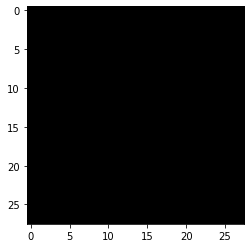

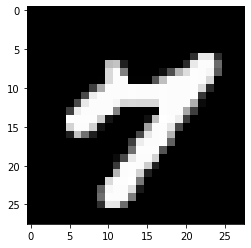

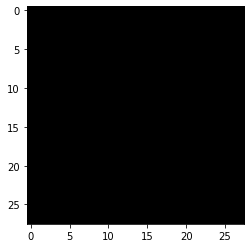

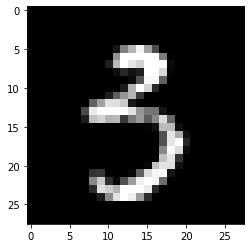

Discriminator_out fake: tensor([[5.7335e-03, 9.9427e-01],
        [6.9326e-04, 9.9931e-01]], device='cuda:0')
Real Img Discriminator Out: tensor([[1.0000e+00, 6.6925e-08],
        [9.9999e-01, 1.3373e-05]], device='cuda:0')


In [78]:
with torch.no_grad():
    
    index = 33
    batch_size = 2
    
    x_sample = x_test[index:index+batch_size].to(device)
    y_sample = y_test[index:index+batch_size]

    generator_input = Generator.getGeneratorInput(y_sample, batch_size).to(device)

    generated = generator(generator_input)
    discriminator_out = discriminator(generated)
    
    real_discriminator_out = discriminator(x_sample)
    
    for i in range(batch_size):
        plot_image(generated[i].reshape((28, 28)).cpu())
        plt.show()
        plot_image(x_sample[i].reshape((28, 28)).cpu())
        plt.show()
        
    
    print(f"Discriminator_out fake: {discriminator_out}\nReal Img Discriminator Out: {real_discriminator_out}")

# Selective GAN

In [20]:
batch_size = 200
epochs = 50

for epoch in range(epochs):
    print(f'Epoch: {epoch}')
    losses = [0, 0, 0, 0]
    for i in range(0, len(x_train), batch_size):
        start_index = i
        end_index = i+batch_size
        
        x_batch = x_train[start_index:end_index]
        y_batch = y_train[start_index:end_index]
    
        
        # ------------ Train with real image ----------------
        real = Discriminator.generate_labels(batch_size)
        fake = Discriminator.generate_labels(batch_size, real=False)
        
        features = fe(x_batch)
        discriminator_out = discriminator(features)
        classifier_out = classifier(features)
        
        loss_discriminator = binary_cross_entropy(discriminator_out, real)
        loss_classifier = binary_cross_entropy(classifier_out, y_batch)
        
        loss = loss_discriminator + loss_classifier
        loss.backward()
        discriminator.optimize(0.1)
        classifier.optimize(0.1)
        fe.optimize(0.1)
        
        losses[0] += float(loss)
        
        # --------------- Train with fake image -------------------

        generator_input = Generator.getGeneratorInput(y_batch, batch_size)
        
        generated = generator(generator_input)
        features = fe(generated)
        discriminator_out = discriminator(features)
        classifier_out = classifier(features)
        
        loss_discriminator = binary_cross_entropy(discriminator_out, fake)
        loss_generator = binary_cross_entropy(discriminator_out, real)
        loss_classifier = binary_cross_entropy(classifier_out, y_batch)
        loss = loss_discriminator + loss_classifier
        
        loss.backward(retain_graph=True)
        
        discriminator.optimize(0.1)
        fe.optimize(0.1)
        
        generator.zero_grad()
        loss_generator.backward()
        generator.optimize(0.1)
        
        losses[1] += float(loss_discriminator)
        losses[2] += float(loss_classifier)
        losses[3] += float(loss_generator)
        
    print(f'  Losses: {losses}')

Epoch: 0


NameError: ignored

In [0]:
with torch.no_grad():
    
    index = 133
    batch_size = 2
    
    x_sample = x_test[index:index+batch_size]
    y_sample = y_test[index:index+batch_size]
    
    generator_input = Generator.getGeneratorInput(y_sample, batch_size)
        
    generated = generator(generator_input)
    features = fe(generated)
    discriminator_out = discriminator(features)
    
    features = fe(x_sample)
    real_discriminator_out = discriminator(features)
    classifier_out = classifier(features)

    
    for i in range(batch_size):
        plot_image(generated[i].reshape((28, 28)))
        plt.show()
        plot_image(x_sample[i].reshape((28, 28)))
        plt.show()
        
    
    print(f"Discriminator_out fake: {discriminator_out}\nReal Img Discriminator Out: {real_discriminator_out}")
    print(f"\nClass: {classifier_out}\nReal class: {y_sample}")

In [0]:
with torch.no_grad():
    index = 133
    x_sample = x_test[index:index+2]
    y_sample = y_test[index:index+2]
    y_pred = classifier(fe(x_sample))
    print(y_pred)
    print(y_sample)